In [48]:
# Author: Chun-Yi Chen

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import os 
from sklearn import metrics
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML
from IPython.display import Markdown
import re

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
os.chdir('/content/drive/MyDrive/WebMining')
os.listdir()


['img', 'Final_bert.csv', 'data', 'Final_bert_top15.csv']

# EDA and data preprocessing 

In [52]:
books = pd.read_csv(r"data/Clean book data.csv",index_col=0)
rating = pd.read_csv(r"data/Ratings.csv")
user = pd.read_csv(r"data/Users.csv")
rating_copy = rating.copy()

In [53]:
def rate_mapping(x):
  if x <= 2:
    return 0
  elif x <= 4:
    return 1
  elif x <= 6:
    return 2
  elif x <= 8:
    return 3
  elif x <= 10:
    return 4
      

In [54]:
rating.iloc[:,-1] = rating_copy.iloc[:,-1].apply(lambda x:rate_mapping(x))

Text(0.5, 0, 'Book-Rating')

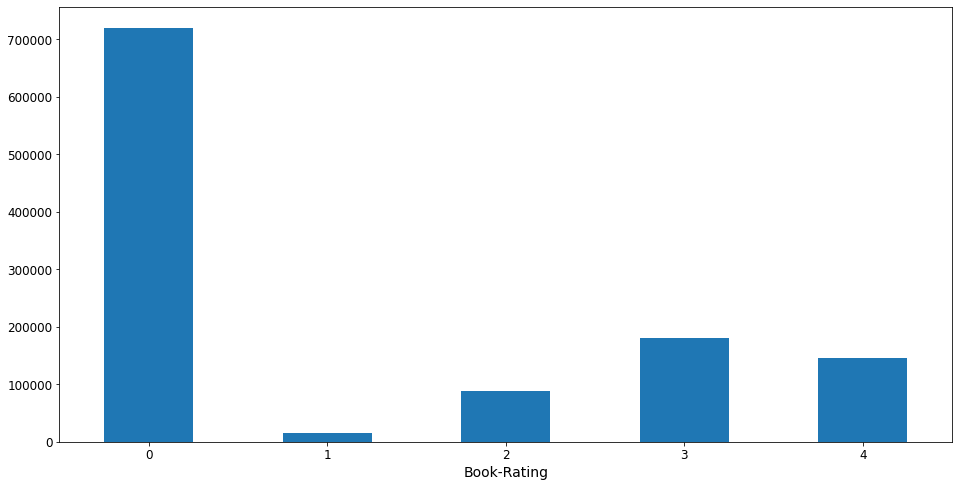

In [55]:
plt.figure(figsize = (16,8))
rating.groupby("Book-Rating").count()["ISBN"].plot(kind = "bar",legend = None)
plt.yticks(fontsize = 12)
plt.xticks(rotation = 0,fontsize = 12)
plt.xlabel("Book-Rating",fontsize = 14)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


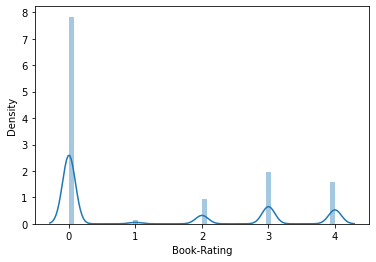

In [56]:
sns.distplot(rating.iloc[:,-1])

In [57]:
# there's some books with the same ISBN
books[~books.index.isin(books.drop_duplicates(subset=["ISBN"]).index)].ISBN

8631    006103097X
8633    0380763621
8637    0380709937
8641    0380715740
8643    0380709945
8649    0394547020
8651    0553204262
8656    0671460978
8663    0060611626
8668    0671578294
8678    0671665790
8680    0395276284
8682    0140094296
8692    0066620996
8694    0446667900
8705    0553579312
8707    055357924X
8709    0425153088
8713    0425141977
8715    0060616598
8717    0802130720
8726    0140043888
8744    0804114897
8750    0804111421
9960    087975446X
9964    0842329293
Name: ISBN, dtype: object

In [58]:
# the data is slightly different 
books[books.ISBN == "006103097X"]

,Id,Name,RatingDist1,pagesNumber,RatingDist4,RatingDistTotal,PublishMonth,PublishDay,Publisher_x,CountsOfReview,...,PagesNumber,Book-Title,Book-Author,Year-Of-Publication,Publisher_y,Image-URL-S,Image-URL-M,Image-URL-L,Genre,Genre_user_amount
8630,76760,"Hope to Die (Matthew Scudder, #15)",1:14,400,4:925,total:2114,5,11,HarperTorch,130,...,NaN,Hope to Die: A Matthew Scudder Crime Novel (Ma...,Lawrence Block,2002,HarperTorch,http://images.amazon.com/images/P/006103097X.0...,http://images.amazon.com/images/P/006103097X.0...,http://images.amazon.com/images/P/006103097X.0...,Mystery|Fiction|Mystery|Crime|Mystery|Detectiv...,87|44|38|12|11|6|5|4|3|3|
8631,76760,"Hope to Die (Matthew Scudder, #15)",1:14,400,4:926,total:2115,5,11,HarperTorch,130,...,NaN,Hope to Die: A Matthew Scudder Crime Novel (Ma...,Lawrence Block,2002,HarperTorch,http://images.amazon.com/images/P/006103097X.0...,http://images.amazon.com/images/P/006103097X.0...,http://images.amazon.com/images/P/006103097X.0...,Mystery|Fiction|Mystery|Crime|Mystery|Detectiv...,87|44|38|12|11|6|5|4|3|3|


In [59]:
books = books.drop_duplicates(subset=["ISBN"])

In [60]:
print("Number of unique rating:",len(rating.loc[:,["User-ID","ISBN"]].drop_duplicates()))
print("Number of unique user id:",len(rating.loc[:,["User-ID"]].drop_duplicates()))
print("Number of unique ISBN:",len(rating.loc[:,["ISBN"]].drop_duplicates()))
rating.head()

Number of unique rating: 1149780
Number of unique user id: 105283
Number of unique ISBN: 340556


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,2
2,276727,0446520802,0
3,276729,052165615X,1
4,276729,0521795028,2


In [61]:
# since we don't have all books in the database
# we need to remove part of the rating that not include in our books dataset
book_ISBN_list = books.ISBN.unique().tolist()
rating_ISBN = rating.ISBN
Filtered_rating = rating[rating_ISBN.isin(book_ISBN_list)].reset_index(drop = True)
Filtered_rating.head()

,User-ID,ISBN,Book-Rating
0,276746,0553561618,0
1,276747,0679776818,3
2,276748,0747558167,2
3,276762,034544003X,0
4,276798,3548603203,2


In [62]:
Filtered_rating.groupby(by = "User-ID").count().head()

,ISBN,Book-Rating
User-ID,,
9,1,1
39,1,1
44,1,1
67,1,1
75,1,1


In [63]:
books_Genre = pd.DataFrame(books.Genre.str.split("|",expand=True))
Genre_count = books_Genre.groupby(by = 1).count().iloc[1:,:]

In [64]:
filter_count = Genre_count[Genre_count>30].dropna().sort_values(by = 0)
print(filter_count.shape)

(32, 10)


In [65]:
file_path = os.path.abspath(os.path.curdir)
results_dir = os.path.join(file_path, 'img/')

In [66]:
def plot_barh(data,xlabel,ylabel,title,savename,xtickfont = 10, ytickfont = 10,figsize = (10,6)):
    file_path = os.path.abspath(os.path.curdir)
    results_dir = os.path.join(file_path, 'img/')
    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)

    
    plt.figure(figsize=figsize)
    plt.barh(width = data.iloc[:,0], y = data.index)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.yticks(fontsize=ytickfont)
    plt.title(title, fontsize = 14)
    plt.tight_layout()
    plt.savefig(results_dir + savename)

In [67]:
def plot_dist(data,xlabel,ylabel,title,savename,xtickfont = 10, ytickfont = 10,figsize = (10,6),Bin = 10, xlim = None):
    file_path = os.path.abspath(os.path.curdir)
    results_dir = os.path.join(file_path, 'img/')
    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)

    
    plt.figure(figsize=figsize)
    sns.distplot(data,bins=Bin,kde=False)
    plt.ylabel(ylabel, fontsize = 18)
    plt.xlabel(xlabel, fontsize = 18)
    plt.xticks(fontsize=xtickfont)
    plt.yticks(fontsize=ytickfont)
    if xlim != None:
        plt.xlim(xlim)
    plt.title(title, fontsize = 20)
    plt.tight_layout()
    plt.savefig(results_dir + savename)

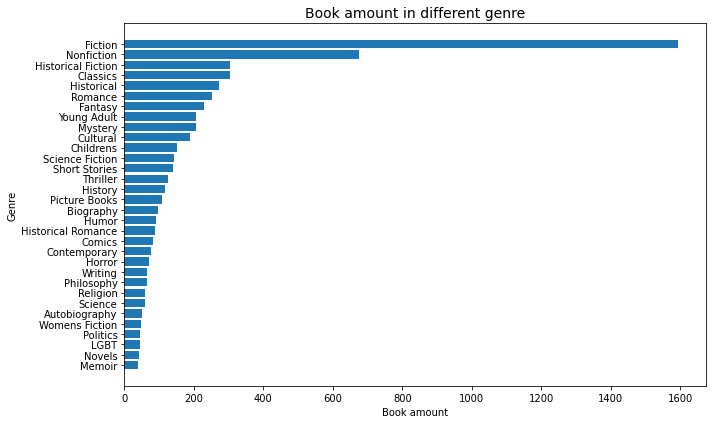

In [68]:
plot_barh(filter_count,"Book amount","Genre","Book amount in different genre","Book amount in different genre.png")

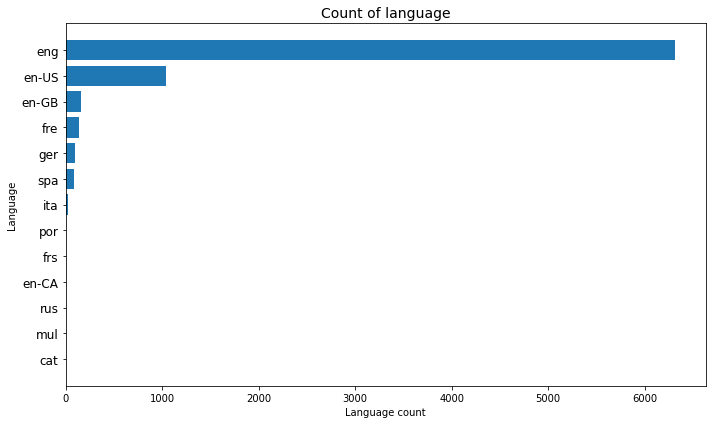

In [69]:
plot_barh(books.groupby(by = "Language").count().sort_values(by = "Id"),"Language count","Language","Count of language","Count of language.png",ytickfont=12)

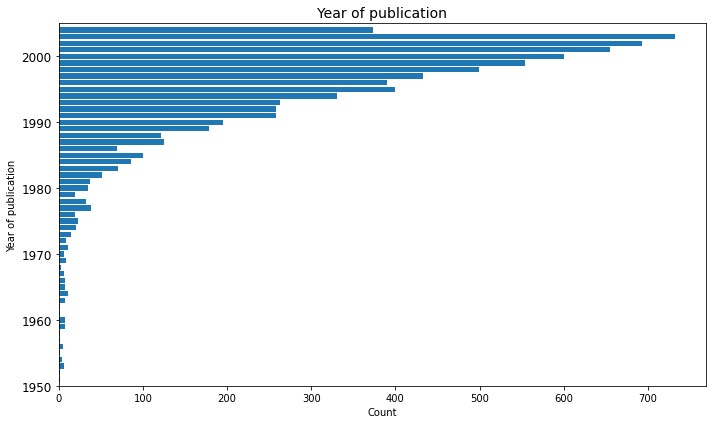

In [70]:
plot_barh(books.groupby(by = "Year-Of-Publication").count().sort_values(by = "Id"),"Count","Year of publication","Year of publication","Count of Year of publication.png",ytickfont=12)
plt.ylim(1950,2005)
plt.tight_layout()
plt.savefig(results_dir + "Count of Year of publication.png")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-10.0, 400.0)

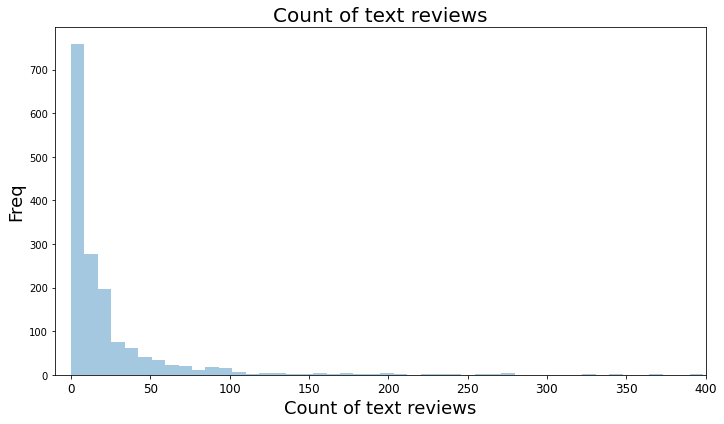

In [71]:
plot_dist(books.loc[:,"Count of text reviews"].dropna(),"Count of text reviews","Freq","Count of text reviews","Count of text reviews.png",xtickfont=12,Bin= 100)
plt.xlim(-10,400)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-0.5, 10.5)

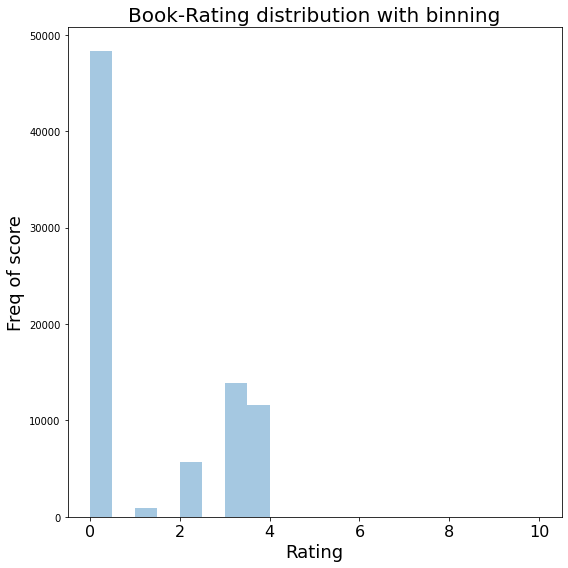

In [135]:
plot_dist(Filtered_rating.loc[:,"Book-Rating"],"Rating","Freq of score","Book-Rating distribution with binning","Book-Rating distribution.png",figsize=(8,8),xtickfont=16,Bin=8)
plt.xlim(-0.5,10.5)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-0.5, 10.5)

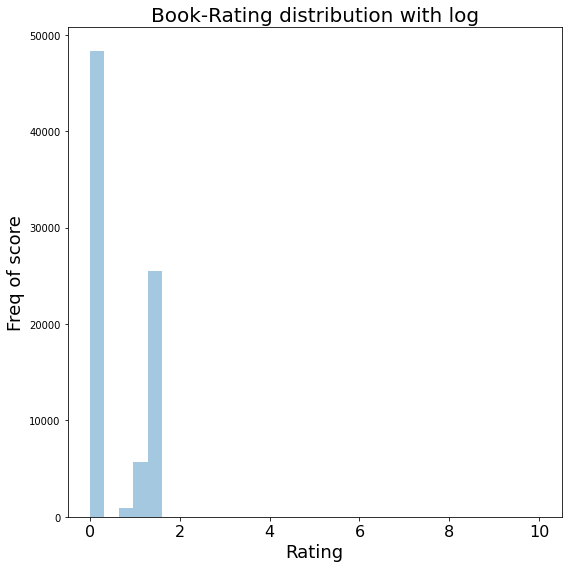

In [137]:

plot_dist(np.log1p(Filtered_rating.loc[:,"Book-Rating"]),"Rating","Freq of score","Book-Rating distribution with log","Book-Rating distribution.png",figsize=(8,8),xtickfont=16,Bin=5)
plt.xlim(-0.5,10.5)

# Genre Adjustment

In [74]:
Genre = "[\""+books.Genre.str.replace("|","\",\"")+"\"]"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [75]:
Genre_expand = Genre.apply(lambda x: eval(x)).apply(pd.Series.value_counts).fillna(0)

In [76]:
top_20_genre = Genre_expand.sum().sort_values(ascending = False).iloc[1:].index

In [77]:
others_genre = Genre_expand.sum().sort_values(ascending = False).iloc[21:].index
Genre_copy = Genre.copy()


In [78]:
Genre_copy_list = Genre_copy.apply(lambda x:eval(x))
def replacer(x):
    for k,i in enumerate(x):
        if i in others_genre:
            x[k] = "others"
    return x
Genre_copy_list = Genre_copy_list.apply(lambda x:replacer(x))
Genre_copy_list = Genre_copy_list.apply(lambda x: np.unique(np.array(x))[1:])

In [79]:
Genre_copy_list.apply(lambda x:"|".join(x.tolist()))

0        Adventure|Childrens|Fantasy|Fiction|Young Adul...
1        Adventure|Childrens|Fantasy|Fiction|Young Adul...
3        Adventure|Classics|Fantasy|Fiction|Humor|Novel...
5               Historical|History|Humor|Nonfiction|others
7        Adventure|Cultural|History|Humor|Nonfiction|ot...
                               ...                        
30243                                       Romance|others
30246                               Science Fiction|others
30257                   Cultural|History|Nonfiction|others
30261                               Fiction|Romance|others
30280                 Childrens|Fiction|Young Adult|others
Name: Genre, Length: 7889, dtype: object

In [80]:
books.Genre = Genre_copy_list.apply(lambda x:"|".join(x.tolist()))

In [81]:
# as long as we filtered the user rating less than 1 time
# the ramaining rate will be lower than 40% 
# our user amount is too much for this amount of books so we filtered it
conditon_func = lambda x : len(x) >= 2
rating_f = Filtered_rating.groupby(by = "User-ID").filter(conditon_func)
book_rating_list = rating_f.ISBN.unique().tolist()
Filtered_books = books[books.ISBN.isin(book_rating_list)]

print(f"Preserve rate of books : {len(rating_f.ISBN.unique())}")
print(f"Preserve rate of books : {len(rating_f.ISBN.unique())/len(Filtered_books.ISBN.unique())*100:.2f}%")
print(f"Preserve rate of users : {len(rating_f.loc[:,'User-ID'].unique())}")
print(f"Preserve rate of users : {len(rating_f.loc[:,'User-ID'].unique())/len(Filtered_rating.loc[:,'User-ID'].unique())*100:.2f}%")


Preserve rate of books : 7462
Preserve rate of books : 100.00%
Preserve rate of users : 8359
Preserve rate of users : 38.39%


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


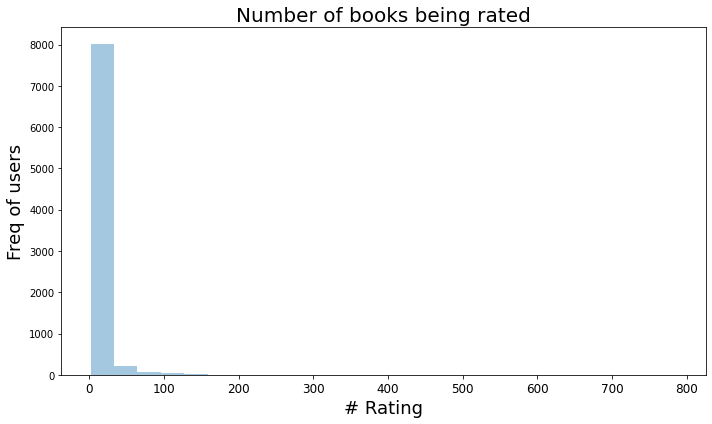

In [82]:
# (almost 70% )most of the users are only rating once
plot_dist(rating_f.groupby(by = "User-ID").size(),"# Rating","Freq of users","Number of books being rated","Number of books being rated.png",xtickfont=12,Bin=25)

# Collaborative Filtering RS

In [83]:
rating_f1 = pd.merge(Filtered_books[["ISBN"]],rating_f,on = "ISBN", how = "right")
rating_f1.head()

,ISBN,User-ID,Book-Rating
0,0688172377,276875,0
1,8806155873,276875,0
2,0140154078,276925,2
3,0151010633,276925,0
4,0316666343,276925,0


In [84]:
# create UserID-ISBN sparse matrix
rating_f2 = rating_f1.pivot_table(index="ISBN", columns="User-ID",values="Book-Rating").fillna(0)
rating_f2.head()

User-ID,114,165,242,243,254,272,383,388,408,424,...,278418,278535,278545,278552,278582,278586,278633,278637,278771,278843
ISBN,,,,,,,,,,,,,,,,,,,,,
0002317850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0002727463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0006163831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0006345530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0006512674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
user_correlation =  1 - pairwise_distances(rating_f2.T, metric="cosine")
user_correlation[np.isnan(user_correlation)] = 0

In [86]:
item_correlation =  1 - pairwise_distances(rating_f2, metric="cosine")
item_correlation[np.isnan(item_correlation)] = 0

In [87]:
print(f"Shape of user similarity matrix:{user_correlation.shape}")
print(f"Shape of item similarity matrix:{item_correlation.shape}")

Shape of user similarity matrix:(8359, 8359)
Shape of item similarity matrix:(7462, 7462)


In [88]:
# copied from the lab1
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
        #pred = 0 + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        mean_item_rating = ratings.mean(axis=0)
        ratings_diff = (ratings - mean_item_rating[np.newaxis, :])
        #pred = 0 + ratings_diff.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        # not sure why this is not a np.array so can't apply clip
        pred = mean_item_rating[np.newaxis, :] + ratings_diff.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred = np.array(pred)
    elif type == 'content':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred = np.array(pred)
    return pred.clip(min = 0)

In [89]:
user_prediction = predict(rating_f2.T, user_correlation, type='user').clip(min = 0)
item_prediction = predict(rating_f2.T, item_correlation, type='item').clip(min = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_laun

In [90]:
user_pred_df = pd.DataFrame(user_prediction, columns = list(Filtered_books.ISBN)).fillna(0)
item_pred_df = pd.DataFrame(item_prediction, columns = list(Filtered_books.ISBN)).fillna(0)

In [91]:
def recommend_books(pred_df, userID, books, original_ratings, num_recommendations, method_name):
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = pred_df.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    original_ratings = original_ratings.sort_values(by= "User-ID",ascending=False)
    # Get the user's data and merge in the books information.
    
    # ID might not exist so pick up a user that actually exist
    real_ID_list = original_ratings.drop_duplicates(subset ="User-ID").loc[:,"User-ID"]
    real_ID = real_ID_list.iloc[user_row_number]
    user_data = original_ratings[original_ratings.loc[:,"User-ID"] == (real_ID)]
    user_full = (user_data.merge(books, how = 'left', left_on = 'ISBN', right_on = 'ISBN').
                     sort_values(['Book-Rating'], ascending=False)
                 )
    
    # Recommend the highest predicted rating books that the user hasn't seen yet.
    recommendations = (books[~books['ISBN'].isin(user_full['ISBN'])].
         merge(pd.DataFrame(sorted_user_predictions).rename_axis('ISBN').reset_index(), how = 'left',
               left_on = 'ISBN',
               right_on = 'ISBN').
         rename(columns = {user_row_number: method_name}).
         sort_values(method_name, ascending = False).
                       iloc[:num_recommendations, :]
                      )
    # specify column for user/item base
    try:
        user_full = user_full.loc[:,["Id","Name","ISBN","Publisher_x","Genre"]]
        recommendations = recommendations.loc[:,["Id","Name","ISBN","Publisher_x","Genre", method_name]]
    except:
        pass
    return user_full, recommendations

In [92]:
# user 2
print("Collaborative Filtering RS (user-based)")
user_full, recommendations = recommend_books(user_pred_df, 2, Filtered_books, rating_f1, 10, 'CF_user_pred_rating')
recommendations


Collaborative Filtering RS (user-based)


,Id,Name,ISBN,Publisher_x,Genre,CF_user_pred_rating
315,9444,The Complete Collected Poems,067942895X,Random House,Classics|Cultural|Literature|Nonfiction|others,2.567089
3254,81039,"Silver Birch, Blood Moon",0380786222,Eos,Fantasy|Fiction|others,0.707560
1433,39305,"Minion (Vampire Huntress, #1)",0312987013,St. Martin's Paperback,Fantasy|Fiction|Romance|others,0.298222
1424,38951,The Day My Butt Went Psycho,0439424690,"Scholastic, Inc.",Adventure|Childrens|Cultural|Fantasy|Fiction|H...,0.179021
3267,81840,Murder Machine,0451403878,Berkley Books,Crime|History|Mystery|Nonfiction|others,0.168572
5703,159299,KnitLit: Sweaters and Their Stories...and Othe...,0609808249,Harmony,Nonfiction|others,0.105618
4555,110457,Nadja,0802150268,Grove Press,Classics|Cultural|European Literature|Fiction|...,0.100767
2412,61924,"Freedom's Choice (Catteni, #2)",0441005314,Ace,Adventure|Fantasy|Fiction|Romance|Science Fict...,0.095850
2965,76969,"The Secret of the Caves (The Hardy Boys, #7)",0448089076,Grosset & Dunlap,Adventure|Childrens|Classics|Fiction|Mystery|Y...,0.086588
1691,45181,Five Children and It (Five Children #1),0140367357,Puffin,Adventure|Childrens|Classics|European Literatu...,0.082171


In [93]:
# item 1
print('Collaborative Filtering RS (item-based)')
user_full, recommendations = recommend_books(item_pred_df, 2, Filtered_books, rating_f1, 10, 'CF_item_pred_rating')
recommendations

Collaborative Filtering RS (item-based)


,Id,Name,ISBN,Publisher_x,Genre,CF_item_pred_rating
7072,1171871,Monet: The Ultimate Impressionist,0810928833,Harry N. Abrams,Nonfiction|others,0.386596
7131,1179722,In Praise of Younger Men (Three Heroes #1; Com...,0451203801,Signet,Fiction|Historical|Romance|others,0.231597
5364,144112,"Brotherhood of the Wolf (Runelords, #2)",0812570693,Tor Fantasy,Adventure|Fantasy|Fiction|others,0.226384
315,9444,The Complete Collected Poems,067942895X,Random House,Classics|Cultural|Literature|Nonfiction|others,0.206081
7153,1182325,High Hopes: The Amityville Murders,0440135427,Dell,Crime|Fantasy|Nonfiction|others,0.203254
651,17658,Trauma,0451205553,Signet,Fantasy|Fiction|others,0.203254
447,12335,Savage Beauty: The Life of Edna St. Vincent Mi...,0375760814,Random House Trade,History|Nonfiction|others,0.180071
5185,135920,"The Fourth Deadly Sin (Deadly Sins, #5)",0425090787,Berkley,Crime|Fiction|Mystery|Thriller|others,0.175072
1433,39305,"Minion (Vampire Huntress, #1)",0312987013,St. Martin's Paperback,Fantasy|Fiction|Romance|others,0.170935
5234,138009,The Listeners,0812550390,Tor Books,Fantasy|Fiction|Mystery|Novels|Science Fiction...,0.166204


In [94]:
# user 1
print("Collaborative Filtering RS (user-based)")
user_full, recommendations = recommend_books(user_pred_df, 1, Filtered_books, rating_f1, 10, 'CF_user_pred_rating')
recommendations


Collaborative Filtering RS (user-based)


,Id,Name,ISBN,Publisher_x,Genre,CF_user_pred_rating
3251,81039,"Silver Birch, Blood Moon",0380786222,Eos,Fantasy|Fiction|others,2.837012
3481,88007,The Wind from Hastings,1568496133,Buccaneer Books,Cultural|Fiction|Historical|Historical Fiction...,0.433009
3254,81122,"Dark Dance (Blood Opera Sequence, #1)",044021274X,Dell,Fantasy|Fiction|others,0.213843
3235,80583,Messengers of God: Biblical Portraits and Legends,067154134X,Simon & Schuster,Literature|Nonfiction|others,0.201147
3242,80763,Use Your Perfect Memory: Dramatic New Techniqu...,0452266068,Plume Books,Nonfiction|others,0.157883
1433,39305,"Minion (Vampire Huntress, #1)",0312987013,St. Martin's Paperback,Fantasy|Fiction|Romance|others,0.157761
5438,148251,The Jaguar Knights,0060555114,Harper Voyager,Adventure|Fantasy|Fiction|Science Fiction|others,0.154690
3233,80518,Four Major Plays 2: Ghosts/An Enemy of the Peo...,0451528034,Signet Classics,Classics|European Literature|Fiction|Literatur...,0.144415
3264,81840,Murder Machine,0451403878,Berkley Books,Crime|History|Mystery|Nonfiction|others,0.142688
3243,80781,The Perfect Summer,0553584049,Bantam,Fiction|Mystery|Romance|others,0.139807


In [95]:
# item 2
print('Collaborative Filtering RS (item-based)')
user_full, recommendations = recommend_books(item_pred_df, 1, Filtered_books, rating_f1, 10, 'CF_item_pred_rating')
recommendations

Collaborative Filtering RS (item-based)


,Id,Name,ISBN,Publisher_x,Genre,CF_item_pred_rating
5424,147802,Black Water 2: More Tales of the Fantastic,0517575590,Three Rivers Press,Cultural|Fantasy|Fiction|Literature|others,0.816916
447,12335,Savage Beauty: The Life of Edna St. Vincent Mi...,0375760814,Random House Trade,History|Nonfiction|others,0.365231
5230,138009,The Listeners,0812550390,Tor Books,Fantasy|Fiction|Mystery|Novels|Science Fiction...,0.339044
5311,141828,L'Écume des jours,2253140872,Le Livre de Poche,Classics|Cultural|European Literature|Fantasy|...,0.288788
5200,136993,Whispers: The Voices of Paranoia,0684802856,Simon & Schuster,Nonfiction|others,0.257030
1496,40995,Sword & Citadel (The Book of the New Sun #3-4),0312890184,Orb Books,Fantasy|Fiction|Science Fiction|others,0.243421
2051,52785,To Jerusalem and Back,0141180757,Penguin Classics,Cultural|History|Literature|Nonfiction|others,0.235871
3452,87247,Der Steppenwolf,3518366750,Suhrkamp,Classics|Cultural|European Literature|Fiction|...,0.230785
6273,185825,"The Stone Canal (The Fall Revolution, #2)",0812568648,Tor Science Fiction,Fiction|Novels|Science Fiction|others,0.180776
1433,39305,"Minion (Vampire Huntress, #1)",0312987013,St. Martin's Paperback,Fantasy|Fiction|Romance|others,0.168406


In [96]:
user_full

,Id,Name,ISBN,Publisher_x,Genre
1,77649,The Bonesetter's Daughter,0399146431,G.P. Putnam's,Cultural|Fiction|Historical|Historical Fiction...
0,48899,Mary Anne and the Silent Witness (Baby-Sitters...,0590228684,Scholastic,Childrens|Fiction|Mystery|Young Adult|others
2,5191,The Pilot's Wife,0316601950,Back Bay Books,Fiction|Mystery|Novels|Romance|others
3,77753,Little Altars Everywhere,0060976845,Harper Perennial,Fiction|Historical|Historical Fiction|Young Ad...
4,131157,Jacqueline Susann's Shadow Of The Dolls,0609605852,Crown,Classics|Fiction|Novels|Romance|others
5,1107332,A Cup of Comfort for Women: Stories that celeb...,158062748X,Cup of Comfort,Nonfiction|others


# content base RS

## TF-IDF

In [97]:
# Create a merge dataframe of book name, genres
# this indicates the content information of the books
book_rating_list = rating_f.ISBN.unique().tolist()
Filtered_books = books[books.ISBN.isin(book_rating_list)]

merge = Filtered_books.loc[:,["Name","ISBN","Genre"]]
merge.Genre = merge.Genre.str.replace(" ","-")
merge.Genre = merge.Genre.str.replace("|"," ")
merge.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


,Name,ISBN,Genre
0,Harry Potter and the Order of the Phoenix (Har...,0439358078,Adventure Childrens Fantasy Fiction Young-Adul...
1,Harry Potter and the Chamber of Secrets (Harry...,0439554896,Adventure Childrens Fantasy Fiction Young-Adul...
3,The Ultimate Hitchhiker's Guide to the Galaxy ...,0345453743,Adventure Classics Fantasy Fiction Humor Novel...
5,A Short History of Nearly Everything,076790818X,Historical History Humor Nonfiction others
7,In a Sunburned Country,0767903862,Adventure Cultural History Humor Nonfiction ot...


In [98]:
merge[merge.isna().any(axis=1)]

,Name,ISBN,Genre


In [99]:
# we already have all we need 
Final = merge.copy()
# for BERT
Final.Genre = Final.Name + " " + Final.Genre
Final.head()

,Name,ISBN,Genre
0,Harry Potter and the Order of the Phoenix (Har...,0439358078,Harry Potter and the Order of the Phoenix (Har...
1,Harry Potter and the Chamber of Secrets (Harry...,0439554896,Harry Potter and the Chamber of Secrets (Harry...
3,The Ultimate Hitchhiker's Guide to the Galaxy ...,0345453743,The Ultimate Hitchhiker's Guide to the Galaxy ...
5,A Short History of Nearly Everything,076790818X,A Short History of Nearly Everything Historica...
7,In a Sunburned Country,0767903862,In a Sunburned Country Adventure Cultural Hist...


In [100]:
Final.columns = ["Name","ISBN","metadata"]

In [101]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
# 7462 books, using 647 terms to describe
print(tfidf_df.shape)

(7462, 8989)


## BERT embedding

In [50]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
# # there's lots of dependency. I recommend to do these task on colab

# # !pip install --upgrade tensorflow
# # !pip install --upgrade tensorflow_hub
import tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub


In [52]:
 
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1", trainable=True)

def get_bert_embeddings(text, preprocessor, encoder):

    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    encoder_inputs = preprocessor(text_input)
    outputs = encoder(encoder_inputs)
    embedding_model = tf.keras.Model(text_input, outputs['pooled_output'])
    sentences = tf.constant([text])
    return embedding_model(sentences)


In [53]:
# you can skip this step if already have the file
Final['encodings'] = Final['metadata'].apply(lambda x: get_bert_embeddings(x, preprocessor, encoder))
# Final = pd.read_csv("Final_bert.csv")

In [54]:
def preprocess_text():
    text = input("Type the words which you want to search:")
    text = text.lower()
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    return text
# you can search anything here and got similarity score in the next cell

query_text = preprocess_text()

Type the word you want to search:boy


In [55]:
query_encoding = get_bert_embeddings(query_text, preprocessor, encoder)

Final['similarity_score'] = Final['encodings'].apply(lambda x: metrics.pairwise.cosine_similarity(x, query_encoding)[0][0])
df_results = Final.sort_values(by=['similarity_score'], ascending=False)

In [56]:
df_results.head(20)

,Name,ISBN,metadata,encodings,similarity_score
29593,Smile,0749312270,Smile Fiction,"((tf.Tensor(-0.9999985, shape=(), dtype=float3...",0.983941
21227,"No Place Like Home (McKenna Family, #1)",037303010X,"No Place Like Home (McKenna Family, #1) Romanc...","((tf.Tensor(-0.9999997, shape=(), dtype=float3...",0.981019
16330,Totally Garlic Cookbook,0890877254,Totally Garlic Cookbook others,"((tf.Tensor(-0.9999961, shape=(), dtype=float3...",0.980872
1333,Not So Big House,1561583766,Not So Big House Nonfiction others,"((tf.Tensor(-0.9999995, shape=(), dtype=float3...",0.980620
22922,Beyond Therapy,0573605742,Beyond Therapy Humor others,"((tf.Tensor(-0.99999744, shape=(), dtype=float...",0.980469
21646,The Honor Price,0373288395,The Honor Price Romance others,"((tf.Tensor(-0.9999994, shape=(), dtype=float3...",0.979625
4757,The Common Good,1878825089,The Common Good Nonfiction others,"((tf.Tensor(-0.99999875, shape=(), dtype=float...",0.978833
24393,Secondhand Husband,0373075006,Secondhand Husband others,"((tf.Tensor(-0.9999994, shape=(), dtype=float3...",0.978612
19652,Making Faces,0316286850,Making Faces Nonfiction others,"((tf.Tensor(-0.9999994, shape=(), dtype=float3...",0.978379
6000,Johnny Thunders: In Cold Blood,1901447154,Johnny Thunders: In Cold Blood Nonfiction others,"((tf.Tensor(-0.9999986, shape=(), dtype=float3...",0.977494


In [211]:
from google.colab import files
df_results.to_csv("Final_bert_top15.csv") 
files.download("Final_bert_top15.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [102]:
tfidf_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,8979,8980,8981,8982,8983,8984,8985,8986,8987,8988
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
content_correlation = linear_kernel(tfidf_matrix, tfidf_matrix)

In [104]:
# (3a)
content_prediction = predict(rating_f2.T, content_correlation, type='content')
content_pred_df = pd.DataFrame(content_prediction, columns = list(Filtered_books.ISBN))
print('Content-based RS with ranking')
user_full, recommendations = recommend_books(content_pred_df, 5, Final, rating_f1, 10, 'CT_3a_pred_rating')
recommendations

Content-based RS with ranking


,Name,ISBN,metadata,CT_3a_pred_rating
6861,The Ultimate Southern Living Cookbook,084871816X,The Ultimate Southern Living Cookbook others,0.057095
6862,Christmas with Southern Living 2000,084871959X,Christmas with Southern Living 2000 others,0.045992
7397,Living at the End of Time,0395445949,Living at the End of Time others,0.031772
2794,"Living Buddha, Living Christ",1573225681,"Living Buddha, Living Christ Nonfiction others",0.030241
1915,Fairy Paths & Spirit Roads: Exploring Otherwor...,1843337045,Fairy Paths & Spirit Roads: Exploring Otherwor...,0.026095
317,Hegel's Phenomenology of Spirit,0198245971,Hegel's Phenomenology of Spirit Classics Europ...,0.020740
312,Living Faith,0812930347,Living Faith Nonfiction others,0.018822
3923,Unmasking the Jezebel Spirit,1584830492,Unmasking the Jezebel Spirit Nonfiction others,0.017835
5472,Original Self: Living with Paradox and Origina...,0060195428,Original Self: Living with Paradox and Origina...,0.017588
1283,The Dragon Doesn't Live Here Anymore: Living F...,0449908402,The Dragon Doesn't Live Here Anymore: Living F...,0.016972


In [105]:
# (3b)
content_prediction = predict(rating_f2.T, content_correlation, type='item')
content_pred_df = pd.DataFrame(content_prediction, columns = list(Filtered_books.ISBN))
print('Content-based RS with ranking')
user_full, recommendations = recommend_books(content_pred_df, 5, Final, rating_f1, 10, 'CT_3b_pred_rating')
recommendations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


Content-based RS with ranking


,Name,ISBN,metadata,CT_3b_pred_rating
1433,"Minion (Vampire Huntress, #1)",0312987013,"Minion (Vampire Huntress, #1) Fantasy Fiction ...",0.170808
3267,Murder Machine,0451403878,Murder Machine Crime History Mystery Nonfictio...,0.078114
923,Anti-Semite and Jew: An Exploration of the Eti...,0805210474,Anti-Semite and Jew: An Exploration of the Eti...,0.071415
4554,Nadja,0802150268,Nadja Classics Cultural European-Literature Fi...,0.063692
1424,The Day My Butt Went Psycho,0439424690,The Day My Butt Went Psycho Adventure Children...,0.062576
5702,KnitLit: Sweaters and Their Stories...and Othe...,0609808249,KnitLit: Sweaters and Their Stories...and Othe...,0.061823
6861,The Ultimate Southern Living Cookbook,084871816X,The Ultimate Southern Living Cookbook others,0.057870
316,The Complete Collected Poems,067942895X,The Complete Collected Poems Classics Cultural...,0.052683
3238,Messengers of God: Biblical Portraits and Legends,067154134X,Messengers of God: Biblical Portraits and Lege...,0.050455
6862,Christmas with Southern Living 2000,084871959X,Christmas with Southern Living 2000 others,0.046414


In [106]:
# (3c)
def pred_norm(similarity, a, b):
    return (b-a)*((similarity-np.min(similarity, axis=1)[np.newaxis, :])/np.max(similarity, axis=1)[np.newaxis, :]-np.min(similarity, axis=1)[np.newaxis, :])+a
content_prediction = pred_norm(content_correlation, 0,5)
content_pred_df = pd.DataFrame(content_prediction, columns = list(Filtered_books.ISBN))
print(content_pred_df.shape)
print('Content-based RS without ranking')
user_full, recommendations = recommend_books(content_pred_df, 5, Final, rating_f1, 10, 'CT_3c_pred_rating')
recommendations

(7462, 7462)
Content-based RS without ranking


,Name,ISBN,metadata,CT_3c_pred_rating
4,In a Sunburned Country,0767903862,In a Sunburned Country Adventure Cultural Hist...,5.000000
9,Coming Into the Country,0374522871,Coming Into the Country Adventure History Nonf...,2.380150
4833,In the Country of the Young,0060937742,In the Country of the Young Cultural Fantasy F...,2.288413
3259,"Dude, Where's My Country?",0446693790,"Dude, Where's My Country? History Humor Litera...",2.200234
2466,"The Country Ahead of Us, the Country Behind",0679767185,"The Country Ahead of Us, the Country Behind Fi...",2.029895
1980,"The Secret Country (The Secret Country, #1)",0142501530,"The Secret Country (The Secret Country, #1) Ad...",1.994519
6287,The Little Country,0312876491,The Little Country Cultural Fantasy Fiction Sc...,1.913603
1236,Up Country,0446611913,Up Country Fiction Historical Historical-Ficti...,1.727329
2381,The Country Under My Skin: A Memoir of Love an...,1400032164,The Country Under My Skin: A Memoir of Love an...,1.678981
5764,My Own Country: A Doctor's Story,0679752927,My Own Country: A Doctor's Story Nonfiction ot...,1.653166


In [107]:
indices = pd.DataFrame(np.array([np.arange(0,len(Final)),Final.ISBN]).T, index=Final['Name'])
def get_recommendations(title, cosine_sim, method_name, num_recommend=10):
    # Get the index of the book that matches the title
    if type(indices.loc[title,0]) is int:
        idx = indices.loc[title,0]
    else:
        idx = indices.loc[title,0].iloc[0]

    # Get the pairwise similarity scores of all books with that book
    sim_scores = list(enumerate(content_prediction[idx]))

    # Sort the books based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the top K most similar books
    sim_scores = sim_scores[1:10]
    
    book_indices = [i[0] for i in sim_scores]
    # Get the book ISBN
    book_ISBN = [indices.iloc[i[0],1] for i in sim_scores]

    # Get the pred scores
    book_pred_score = [i[1] for i in sim_scores]

    # Return the top K most similar books
    return pd.DataFrame({'ISBN': book_ISBN,'Name': list(Final['Name'].iloc[book_indices].values), 'metadata': list(Final['metadata'].iloc[book_indices].values), method_name: book_pred_score})

# Find Similar book

In [108]:
book_search = 'Harry Potter and the Order of the Phoenix (Harry Potter, #5)'
# run with (3a)
# content_prediction = predict(rating_f2.T, content_correlation, type='content')
# content_pred_df = pd.DataFrame(content_prediction, columns = list(Filtered_books.ISBN))
# run with (3b)
content_prediction = predict(rating_f2.T, content_correlation, type='item')
content_pred_df = pd.DataFrame(content_prediction, columns = list(Filtered_books.ISBN))
# default run with (3c)
display(Final[Final.Name==book_search])
print(f"Similar books of {book_search}:")
get_recommendations(book_search, content_prediction, 'CT_3c_pred_rating', num_recommend=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


,Name,ISBN,metadata
0,Harry Potter and the Order of the Phoenix (Har...,0439358078,Harry Potter and the Order of the Phoenix (Har...


Similar books of Harry Potter and the Order of the Phoenix (Harry Potter, #5):


,ISBN,Name,metadata,CT_3c_pred_rating
0,0671009508,"Hot Blood X (Hot Blood, #10)","Hot Blood X (Hot Blood, #10) others",0.078553
1,0451403878,Murder Machine,Murder Machine Crime History Mystery Nonfictio...,0.073769
2,0805210474,Anti-Semite and Jew: An Exploration of the Eti...,Anti-Semite and Jew: An Exploration of the Eti...,0.064711
3,0439424690,The Day My Butt Went Psycho,The Day My Butt Went Psycho Adventure Children...,0.063162
4,0380786222,"Silver Birch, Blood Moon","Silver Birch, Blood Moon Fantasy Fiction others",0.059683
5,0609808249,KnitLit: Sweaters and Their Stories...and Othe...,KnitLit: Sweaters and Their Stories...and Othe...,0.058976
6,0802150268,Nadja,Nadja Classics Cultural European-Literature Fi...,0.054565
7,0671537652,"Fear the Fever (Hot Blood, #7)","Fear the Fever (Hot Blood, #7) others",0.052391
8,067942895X,The Complete Collected Poems,The Complete Collected Poems Classics Cultural...,0.048489


# Hybrid

In [109]:
userid = 2

_, CF_user_pred_rating = recommend_books(user_pred_df, userid, Filtered_books, rating_f1, len(Filtered_books), 'CF_user_pred_rating')
_, CF_item_pred_rating = recommend_books(item_pred_df, userid, Filtered_books, rating_f1, len(Filtered_books), 'CF_item_pred_rating')
content_prediction = predict(rating_f2.T, content_correlation, type='item')
content_pred_df = pd.DataFrame(content_prediction, columns = list(Filtered_books.ISBN))
_, CT_3b_pred_rating = recommend_books(content_pred_df, userid, Filtered_books, rating_f1, len(Filtered_books), 'CT_3b_pred_rating')
Final_hybrid = pd.merge(pd.merge(CF_user_pred_rating,CF_item_pred_rating,on=['ISBN', 'Name', 'Genre']),CT_3b_pred_rating,on=['ISBN', 'Name', 'Genre'])
hybrid_score = ((Final_hybrid.CF_user_pred_rating + Final_hybrid.CF_item_pred_rating + Final_hybrid.CT_3b_pred_rating)/3.0)
Final_hybrid['hybrid_pred_rating'] = hybrid_score

# Sort it on the basis of either: CF_user_pred_rating, CF_item_pred_rating, CT_3b_pred_rating or hybrid_pred_rating, 
# Here : hybrid_pred_rating
Final_hybrid.sort_values('hybrid_pred_rating', ascending=False, inplace = True)

# Recommend top K books based on the input user
Final_hybrid.set_index(['Name']).iloc[1:11]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


,Id_x,ISBN,Publisher_x_x,Genre,CF_user_pred_rating,Id_y,Publisher_x_y,CF_item_pred_rating,Id,Publisher_x,CT_3b_pred_rating,hybrid_pred_rating
Name,,,,,,,,,,,,
"Silver Birch, Blood Moon",81039,0380786222,Eos,Fantasy|Fiction|others,0.707560,81039,Eos,0.088709,81039,Eos,0.039799,0.278689
"Minion (Vampire Huntress, #1)",39305,0312987013,St. Martin's Paperback,Fantasy|Fiction|Romance|others,0.298222,39305,St. Martin's Paperback,0.170935,39305,St. Martin's Paperback,0.169747,0.212968
Monet: The Ultimate Impressionist,1171871,0810928833,Harry N. Abrams,Nonfiction|others,0.009869,1171871,Harry N. Abrams,0.386596,1171871,Harry N. Abrams,0.001431,0.132632
Murder Machine,81840,0451403878,Berkley Books,Crime|History|Mystery|Nonfiction|others,0.168572,81840,Berkley Books,0.076951,81840,Berkley Books,0.074497,0.106673
The Day My Butt Went Psycho,38951,0439424690,"Scholastic, Inc.",Adventure|Childrens|Cultural|Fantasy|Fiction|H...,0.179021,38951,"Scholastic, Inc.",0.071865,38951,"Scholastic, Inc.",0.062656,0.104514
"In Praise of Younger Men (Three Heroes #1; Company of Rogues, #6)",1179722,0451203801,Signet,Fiction|Historical|Romance|others,0.016272,1179722,Signet,0.231597,1179722,Signet,0.000000,0.082623
"Brotherhood of the Wolf (Runelords, #2)",144112,0812570693,Tor Fantasy,Adventure|Fantasy|Fiction|others,0.011478,144112,Tor Fantasy,0.226384,144112,Tor Fantasy,0.000000,0.079287
KnitLit: Sweaters and Their Stories...and Other Writing About Knitting,159299,0609808249,Harmony,Nonfiction|others,0.105618,159299,Harmony,0.061870,159299,Harmony,0.060845,0.076111
High Hopes: The Amityville Murders,1182325,0440135427,Dell,Crime|Fantasy|Nonfiction|others,0.022018,1182325,Dell,0.203254,1182325,Dell,0.000410,0.075228


## Matrix Factorization by using SVD (Surprise Library)

In [110]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 29.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633705 sha256=68d8a28f3647e6624cdfcf5774d9e2eb34799bc3a1f3d0eb6f5d674e660b9bf4
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [111]:
rating_f_copy = rating_f.copy()

In [112]:
rating_f_copy.loc[:,'Book-Rating'] = rating_f_copy.loc[:,'Book-Rating']

In [113]:
rating_f_copy

,User-ID,ISBN,Book-Rating
11,276875,0688172377,0
12,276875,8806155873,0
15,276925,0140154078,2
16,276925,0151010633,0
17,276925,0316666343,0
...,...,...,...
80456,276688,0553572512,3
80457,276688,0553575090,3
80458,276688,0684195569,4
80459,276688,0836218655,4


In [126]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
# Instantiate a reader with the specified rating scale
# and read in the rating data
# without log
rating_f = rating_f_copy.copy()
# with log
# rating_f.loc[:,'Book-Rating'] = np.log1p(rating_f_copy.loc[:,'Book-Rating'])


In [127]:
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(rating_f[['User-ID','ISBN','Book-Rating']], reader)
 
# Train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=0.25, random_state = 0)

In [128]:
# Check the testset
df_test = pd.DataFrame(testset, columns=['User-ID','ISBN','Book-Rating'])
#df_test.head(3)
print("Test data Size: %i" %len(df_test))

df_test.head(3)

Test data Size: 16762


,User-ID,ISBN,Book-Rating
0,110912,0553581767,4.0
1,20115,0312977670,0.0
2,68000,0439424690,0.0


In [129]:
# Train the model on trainset and evaluate on testset
# About the implemented SVD: https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD
algorithm = SVD(n_factors=50)
model_svd = algorithm.fit(trainset)
predictions = model_svd.test(testset)

In [130]:
predictions[:3]


[Prediction(uid=110912, iid='0553581767', r_ui=4.0, est=0.07347786348066203, details={'was_impossible': False}),
 Prediction(uid=20115, iid='0312977670', r_ui=0.0, est=0.6212893344700282, details={'was_impossible': False}),
 Prediction(uid=68000, iid='0439424690', r_ui=0.0, est=0.8132424622823278, details={'was_impossible': False})]

In [131]:
from collections import Counter
from sklearn.metrics import mean_squared_error, mean_absolute_error
from surprise import SVD, NMF, KNNBasic, KNNWithMeans
df_pred = pd.DataFrame(predictions, columns=['User-ID','ISBN','Book-Rating', 'pred_rating', 'details'])
df_pred.head(5)

,User-ID,ISBN,Book-Rating,pred_rating,details
0,110912,0553581767,4.0,0.073478,{'was_impossible': False}
1,20115,0312977670,0.0,0.621289,{'was_impossible': False}
2,68000,0439424690,0.0,0.813242,{'was_impossible': False}
3,191720,3548603254,0.0,1.537950,{'was_impossible': False}
4,173109,0446358584,0.0,0.952060,{'was_impossible': False}


In [132]:
# # Check the accuracy using Root Mean Square Error
print(accuracy.rmse(predictions))
# Check the accuracy using Mean Absolute Error
print(accuracy.mae(predictions))

RMSE: 1.4717
1.47170216372063
MAE:  1.2263
1.2262560543689578


In [133]:
# for log1p
# Check the accuracy using Root Mean Square Error
# from fastai.metrics import mean_absolute_error
print(mean_absolute_error(np.expm1(df_pred.pred_rating),pd.Series(predictions).apply(lambda x: x.est)))
print(np.sqrt(mean_squared_error(np.expm1(df_pred.pred_rating),pd.Series(predictions).apply(lambda x: x.est))))

1.6302344286243085
3.4151752726173563


In [134]:
alg_list = ['SVD(n_factors=50)',
        'SVD(n_factors=100)',
        'SVD(n_factors=150)',
        'KNNBasic(k=20, sim=cosine, item-based)', 
        'KNNBasic(k=20, sim=pearson, user-based)']
sim_option_item = {'name': 'cosine',
              'item_based': False  # compute similarities between items
               }
sim_option_user = {'name': 'pearson',
              'user_based': True  # compute similarities between users
               }
benchmark = []
for i, algorithm in enumerate([SVD(n_factors=50), SVD(n_factors=100), SVD(n_factors=150), KNNBasic(k=20, sim_options=sim_option_item), KNNBasic(k=20, sim_options=sim_option_user)]):
  model_svd = algorithm.fit(trainset)
  predictions = model_svd.test(testset)
  df_pred = pd.DataFrame(predictions, columns=['User-ID','ISBN','Book-Rating', 'pred_rating', 'details'])
  print(alg_list[i])
  print("MAE")
  print(mean_absolute_error(np.expm1(df_pred.pred_rating),pd.Series(predictions).apply(lambda x: x.est)))
  print("RMSE")
  print(np.sqrt(mean_squared_error(np.expm1(df_pred.pred_rating),pd.Series(predictions).apply(lambda x: x.est))))

SVD(n_factors=50)
MAE
1.621609612677808
RMSE
3.3542415288964125
SVD(n_factors=100)
MAE
1.614536543353082
RMSE
3.3765683231045864
SVD(n_factors=150)
MAE
1.5997637376110507
RMSE
3.3883877705025993
Computing the cosine similarity matrix...


/usr/local/lib/python3.7/dist-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
KNNBasic(k=20, sim=cosine, item-based)
MAE
3.5475434813817275
RMSE
9.776069414336662
Computing the pearson similarity matrix...
Done computing similarity matrix.
KNNBasic(k=20, sim=pearson, user-based)
MAE
2.517219313701556
RMSE
7.984782840167916


In [ ]:
from sklearn.model_selection import train_test_split
from surprise.model_selection import cross_validate
reader = Reader(rating_scale=(0, 10))
trainset, testset = train_test_split(rating_f[['User-ID','ISBN','Book-Rating']], test_size=0.25, random_state=0)
trainset.index = range(len(trainset)) 
testset.index = range(len(testset)) 
trainset = Dataset.load_from_df(trainset, reader)
data = Dataset.load_from_df(rating_f[['User-ID','ISBN','Book-Rating']], reader)
#trainset = Dataset.load_from_df(trainset, reader).build_full_trainset()
#testset = Dataset.load_from_df(testset, reader)
testset = testset.values.tolist()
benchmark = []
i = 0
alg_list = ['SVD(n_factors=50)', 'SVD(n_factors=100)', 
            'SVD(n_factors=150)']
for algorithm in [SVD(n_factors=50), SVD(n_factors=100), SVD(n_factors=150)]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([alg_list[i]], index=['Algorithm']))
    benchmark.append(tmp)
    i+=1
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [ ]:
# Train on full training set and evaluate on test set
trainset = trainset.build_full_trainset()
algorithm = SVD(n_factors=50)
model_svd = algorithm.fit(trainset)
predictions = model_svd.test(testset)

In [ ]:
rating_f.rename(columns = {'User-ID':'userID'}, inplace = True)
rating.rename(columns = {'User-ID':'userID'}, inplace = True)

In [ ]:
from surprise import SVD, NMF, KNNBasic, KNNWithMeans
from sklearn.model_selection import train_test_split

## Load the data into surprise input data format, split into training and testing
reader = Reader(rating_scale=(0, 10))
trainset, testset = train_test_split(rating_f[['userID','ISBN','Book-Rating']], test_size=0.2, random_state=0)
trainset.index = range(len(trainset)) 
testset.index = range(len(testset)) 

trainset = Dataset.load_from_df(trainset, reader)
testset = testset.values.tolist()

In [ ]:
display(trainset)


In [ ]:

# Define the models and their hyperparameters 
sim_option_item = {'name': 'cosine',
              'item_based': False  # compute similarities between items
               }
sim_option_user = {'name': 'pearson',
              'user_based': True  # compute similarities between users
               }
benchmark = []
i = 0
alg_list = ['SVD(n_factors=50)',
        'SVD(n_factors=100)',
        'SVD(n_factors=150)',
        'KNNBasic(k=20, sim=cosine, item-based)', 
        'KNNBasic(k=20, sim=pearson, user-based)']

# Iterate over selected algorithms based on 5-fold CV on training set
for algorithm in [SVD(n_factors=50), SVD(n_factors=100), SVD(n_factors=150), KNNBasic(k=20, sim_options=sim_option_item), KNNBasic(k=20, sim_options=sim_option_user)]:
    # Perform cross validation
    
    results = cross_validate(algorithm, trainset, measures=['RMSE','MAE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([alg_list[i]], index=['Algorithm']))
    benchmark.append(tmp)
    i+=1
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

In [ ]:
# Since SVD(n_factors=50) reach the lowest RMSE and MAE
# We use this model to train on whole training set and evaluate the final result on testset
trainset = trainset.build_full_trainset()
algorithm = SVD(n_factors=50)
model_svd = algorithm.fit(trainset)
predictions = model_svd.test(testset)
print(accuracy.rmse(predictions))
print(accuracy.mae(predictions))

In [ ]:


book_list_rating = rating_f.ISBN.unique().tolist()
books_filter = books[books.ISBN.isin(book_list_rating)]
print(len(books_filter))
print('Preserved rate of the books : {0:.2f} %'.format(len(rating_f.ISBN.unique())/len(books_filter.ISBN.unique()) * 100))
print('Preserved rate of the users : {0:.2f} %'.format(len(rating_f.userID.unique())/len(rating_f.userID.unique()) * 100))

rating_f.head(4)

In [ ]:
rating_f.shape[0]

In [ ]:
rating_f

In [ ]:
# Map books to id:
Mapping_file = dict(zip(books_filter.ISBN.tolist(), books_filter.ISBN.tolist()))


In [ ]:
def pred_user_rating(user_id, num_recommend):
    if user_id in rating_f.userID.unique():
        ui_list = rating_f[rating_f.userID == user_id].ISBN.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = algorithm.predict(userid, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['ISBN', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('ISBN', inplace=True)   
        recommend_list = pdf.head(num_recommend)  
        return pdf.head(num_recommend)        
    else:
        print("User Id does not exist in the list!")
        return None

In [ ]:
rating_f.userID.unique()

In [ ]:
user_id = int(input("Enter the user id to whom you want to recommend : "))
num_recommend = int(input("Enter the number of books you want to recommend : "))
pred_user_rating(user_id, num_recommend)

In [ ]:
print("Get recommended books metadata")
rec_books = pred_user_rating(user_id, num_recommend)
rec_books_md = pd.merge(rec_books, books , how='left', left_on='ISBN', right_on='ISBN')[['ISBN','Name','Genre']]
display(rec_books_md.head(5))

print(len(rating_f[rating_f.userID==110912]))
rating_f[rating_f.userID==110912].merge(books).sort_values('Book-Rating', ascending=False)

In [ ]:
trainset, testset = train_test_split(rating_f[['userID','ISBN','Book-Rating']], test_size=0.25, random_state=0)
trainset.index = range(len(trainset)) # 75627
testset.index = range(len(testset))
print(len(testset[testset.userID==2]))
check = testset[testset.userID==2]
check.index = range(len(check))
check.merge(books)


In [ ]:
# from fastai.collab import *
# from fastai.tabular import *



## POPULARITY BASED RECOMMENDATION SYSTEM

In [ ]:
rating_list = pd.merge(Filtered_books[["ISBN","Name","Genre"]],rating_f,on = "ISBN", how = "right")
rating_list = rating_list.replace('\\\\', ' ',regex=True)
rating_list = rating_list.replace('/', ' ',regex=True)
rating_list = rating_list.replace('\+', '',regex=True)
rating_list.head()

In [ ]:
rating_count = pd.DataFrame(rating_list['Name'].value_counts())
rating_count['Total-Ratings'] = rating_count['Name']
rating_count['Name'] = rating_count.index
rating_count.reset_index(level=0, inplace=True)
rating_count = rating_count.drop('index',axis=1)


In [ ]:

def avgRating(rating_count, rating_list):
    rating_count['Average-Rating'] = 0
    rating_count['Genre'] = ''
    for x in rating_count.Name:
        l = rating_list.loc[rating_list['Name'] == x]
        r = rating_count.loc[rating_count['Name'] == x]
        rating_count.loc[rating_count['Name'].str.match(x),'Average-Rating'] = sum(l['Book-Rating'])/len(l)
        rating_count.loc[rating_count['Name'].str.match(x),'Genre'] = l['Genre'].iloc[0]
    return rating_count

rating_count = avgRating(rating_count, rating_list)
rating_count
# df.to_pickle('weightedData')
# df = pd.read_pickle('weightedData')

In [ ]:
## C - Mean vote across the whole
C = rating_count['Average-Rating'].mean()

## Minimum number of votes required to be in the chart
m = rating_count['Total-Ratings'].quantile(0.90)

In [ ]:
def weighted_rating(x, m=m, C=C): 
    v = x['Total-Ratings']    #v - number of votes
    R = x['Average-Rating']   #R - Average Rating   
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
df = rating_count.loc[rating_count['Total-Ratings'] >= m]
df['score'] = df.apply(weighted_rating, axis=1)
df = df.sort_values('score', ascending=False)
number=10
print("Recommended Books:-\n")
df.head(number)


## The Best Book Finder for You

In [ ]:
# Showing Top10 Tranding Movie using Popularity Based Method

display(Markdown('<h1><center><strong><span style="color:DarkSlateGrey">{}</span></strong></center></h1>'.format("Best Book Finder For You")))
display(Markdown('<h2><center><strong><span style="color:CadetBlue">{}</span></strong></center></h2>'.format("Ready to Find the Next Book?")))
display(Markdown('<hr>'))

display(Markdown('<h3><em><span style="color:DarkSlateGrey">{}</span></em></h3>'.format("Top 10 Tranding Movies Now")))
index_list = list(range(1, number+1))
new_df = new_df.set_index(pd.Series(index_list))
display(new_df[['Name','Genre']])
display(Markdown('<br>'))
display(Markdown('<h3><code style="background:SlateGray;color:white">{}</code>&nbsp&nbsp<code style="background:SlateGray;color:white">{}</code>&nbsp&nbsp<code style="background:SlateGray;color:white">{}</code></h3>'.format(" 1. Find Similiar "," 2. Personal Recommendation "," 3.End ")))



task = int(input("Enter the task: "))
while task!=3:
    if task==1:
        book_search = input("Tell me the book you like before: ")
        # Test Book 'Harry Potter and the Order of the Phoenix (Harry Potter, #5)'
        display(Markdown('<br>'))
        display(Markdown('<h3><span style="color:DarkSlateGrey">{}</span><span style="color:CadetBlue">{}</span></h3>'.format("The Detail info of ",str(book_search))))
        display(Markdown('<hr>'))
        display(Final[Final.Name==book_search])
        display(Markdown('<h3><span style="color:DarkSlateGrey">{}</span><span style="color:CadetBlue">{}</span><span style="color:DarkSlateGrey">{}</span></h3>'.format("Because you like ",str(book_search),", we found some books you probably like.")))
        display(Markdown('<hr>'))
        display(get_recommendations(book_search, content_prediction, 'CT_3c_pred_rating', num_recommend=10)[['Name','metadata']])
    else:
        user_id = int(input("Enter your user id : "))
        # Test user_id 276875
        num_recommend = int(input("Enter the number of books you want to recommend : "))
        display(Markdown('<h3><span style="color:DarkSlateGrey">{}</span><span style="color:CadetBlue">{}</span></h3>'.format("Here is our personal recommendation for you ",str(user_id))))
        rec_books = pred_user_rating(user_id, num_recommend)
        rec_books_md = pd.merge(rec_books, books , how='left', left_on='ISBN', right_on='ISBN')[['ISBN','Name','Genre']]
        display(rec_books_md.head(num_recommend)[['Name','Genre']])
    display(Markdown('<br>'))
    display(Markdown('<h3><code style="background:SlateGray;color:white">{}</code>&nbsp&nbsp<code style="background:SlateGray;color:white">{}</code>&nbsp&nbsp<code style="background:SlateGray;color:white">{}</code></h3>'.format(" 1. Find Similiar "," 2. Personal Recommendation "," 3.End ")))
    task = int(input("Enter the task: "))

    
display(Markdown('<h3><em><span style="color:DarkCyan">{}</span></em></h3>'.format("Thanks for your visiting.")))